In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))

In [2]:
%matplotlib inline

from session.sessions import selected_009266, selected_008229, selected_009265
from imports import *
from loading import load_session_data
from behavior import get_behav_units
from scipy import stats
from scipy import signal
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import decomposition
from sklearn.cluster import DBSCAN

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

### Select behaviorally relevant units

In [4]:
sessions = [s for s in selected_009265.keys()]
sessions.sort()
selected = sessions[:-2]
selected

['009265_hippoSIT_2023-02-24_09-53-26',
 '009265_hippoSIT_2023-02-24_17-22-46',
 '009265_hippoSIT_2023-02-27_10-18-32',
 '009265_hippoSIT_2023-02-27_15-33-46',
 '009265_hippoSIT_2023-02-28_09-16-50',
 '009265_hippoSIT_2023-02-28_13-16-10',
 '009265_hippoSIT_2023-02-28_20-45-04',
 '009265_hippoSIT_2023-03-01_10-46-12',
 '009265_hippoSIT_2023-03-02_09-32-54',
 '009265_hippoSIT_2023-03-02_16-27-42',
 '009265_hippoSIT_2023-03-02_20-11-35',
 '009265_hippoSIT_2023-03-03_09-37-07',
 '009265_hippoSIT_2023-03-03_16-00-47',
 '009265_hippoSIT_2023-03-04_11-12-04',
 '009265_hippoSIT_2023-03-05_11-52-17',
 '009265_hippoSIT_2023-03-05_18-31-32',
 '009265_hippoSIT_2023-03-08_18-10-07',
 '009265_hippoSIT_2023-03-09_20-03-08',
 '009265_hippoSIT_2023-03-10_09-57-34']

In [6]:
behav_units = {}  # takes a while
for session in selected:
    behav_units[session] = get_behav_units(session)
    
unit_count = np.array([len(units) for units in behav_units.values()]).sum()
unit_count

153

### Build feature matrix

In [8]:
syl_count = 10
fet_mx = np.zeros([unit_count, syl_count])  # GLM fit profiles

def to_scaled(vec):
    return vec/(np.abs(vec.min() - vec.max()))

i = 0
s_labels = np.zeros(unit_count)
u_labels = []
sessions = list(behav_units.keys())
for j, (session, units) in enumerate(behav_units.items()):
    animal = session.split('_')[0]
    moseq_file = os.path.join(source, animal, session, 'moseq.h5')
    
    with h5py.File(moseq_file, 'r') as f:
        syl_ratio_mx = np.array(f['syl_ratio_mx'])
        idxs_srm_tl  = np.array(f['idxs_srm_tl'])
        syl_usages   = np.array([syl_ratio_mx[:, i].mean() for i in range(syl_ratio_mx.shape[1])])

        for unit in units:
            grp = f['units'][unit]
            glm_cf_mx = np.array(grp['glm_cf_mx'])
            glm_pv_mx = np.array(grp['glm_pv_mx'])

            # metric - original GLM fit
            #fet_mx[i] = np.array(grp['glm_fit_params'])[1:]  # exclude intercept
            #fet_mx[i] = to_scaled(fet_mx[i]*syl_usages)

            # metric - across train/test means
            means     = np.zeros(syl_count)
            syll_ids = list(np.arange(syl_count).astype(np.int16))
            for idx_syll in syll_ids:
                coeffs = glm_cf_mx[glm_pv_mx[:, idx_syll + 1] < 0.05][:, idx_syll + 1] # 0th is intercept
                if len(coeffs) > 5:  # some coeffs might never be significant
                    means[idx_syll] = coeffs.mean()
            fet_mx[i] = to_scaled(means*syl_usages)
            s_labels[i] = j
            u_labels.append(unit)
            i += 1
            
    print('Session %s done' % session)

Session 009265_hippoSIT_2023-02-24_09-53-26 done
Session 009265_hippoSIT_2023-02-24_17-22-46 done
Session 009265_hippoSIT_2023-02-27_10-18-32 done
Session 009265_hippoSIT_2023-02-27_15-33-46 done
Session 009265_hippoSIT_2023-02-28_09-16-50 done
Session 009265_hippoSIT_2023-02-28_13-16-10 done
Session 009265_hippoSIT_2023-02-28_20-45-04 done
Session 009265_hippoSIT_2023-03-01_10-46-12 done
Session 009265_hippoSIT_2023-03-02_09-32-54 done
Session 009265_hippoSIT_2023-03-02_16-27-42 done
Session 009265_hippoSIT_2023-03-02_20-11-35 done
Session 009265_hippoSIT_2023-03-03_09-37-07 done
Session 009265_hippoSIT_2023-03-03_16-00-47 done
Session 009265_hippoSIT_2023-03-04_11-12-04 done
Session 009265_hippoSIT_2023-03-05_11-52-17 done
Session 009265_hippoSIT_2023-03-05_18-31-32 done
Session 009265_hippoSIT_2023-03-08_18-10-07 done
Session 009265_hippoSIT_2023-03-09_20-03-08 done
Session 009265_hippoSIT_2023-03-10_09-57-34 done


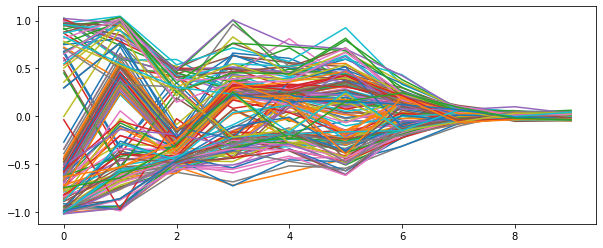

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

#x_vals = np.arange(syl_count)
#x_vals = np.tile(x_vals, unit_count).reshape([unit_count, syl_count])
#ax.plot(x_vals.T, fet_mx.T, c=s_labels)

for i, rec in enumerate(fet_mx):
    ax.plot(rec)

### PCA

In [13]:
pca = decomposition.PCA(n_components=3)
pca.fit(fet_mx)
X = pca.transform(fet_mx)

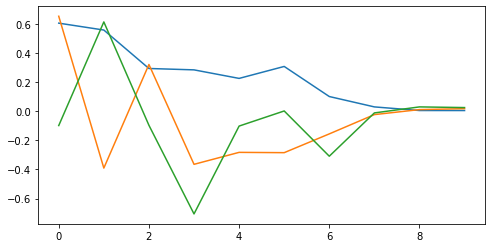

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

for comp in pca.components_:
    ax.plot(comp)

In [29]:
db = DBSCAN(eps=0.21, min_samples=2).fit(X)
np.unique(db.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

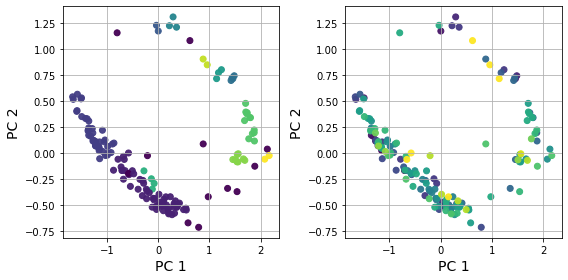

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

#for i, (id_x, id_y) in enumerate([[0, 1], [1, 2], [0, 2]]):
for i, labels in enumerate([db.labels_, s_labels]):
    ax = axes[i]
    id_x, id_y = 0, 1  # Principal components
    ax.scatter(X[:, 0], X[:, 1], alpha=0.95, c=labels)
    #ax.scatter(X[db.labels_ == 2][:, 0], X[db.labels_ == 2][:, 1], alpha=0.95, c='red')
    ax.grid()
    ax.set_xlabel('PC %s' % (id_x + 1), fontsize=14)
    ax.set_ylabel('PC %s' % (id_y + 1), fontsize=14)
    
fig.tight_layout()

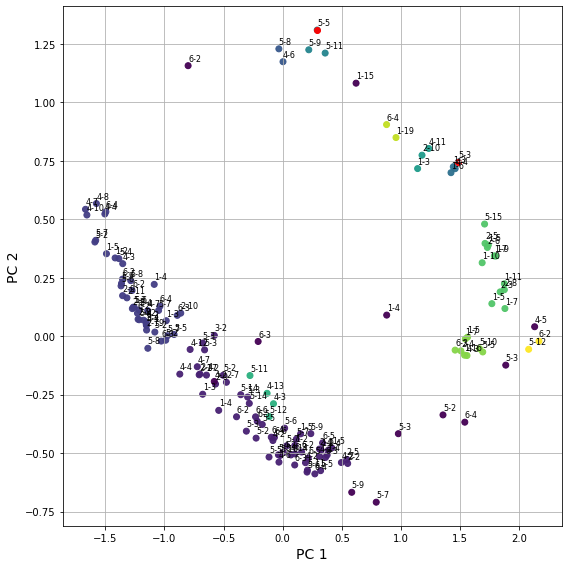

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

id_x, id_y = 0, 1  # Principal components
ax.scatter(X[:, 0], X[:, 1], alpha=0.95, c=db.labels_)
ax.scatter(X[:, 0][9:11], X[:, 1][9:11], alpha=0.95, c='red')
#ax.scatter(X[db.labels_ == 0][:, 0], X[db.labels_ == 0][:, 1], alpha=0.5, c='black')
#ax.scatter(X[db.labels_ == 1][:, 0], X[db.labels_ == 1][:, 1], alpha=0.95, c='red')
ax.grid()
ax.set_xlabel('PC %s' % (id_x + 1), fontsize=14)
ax.set_ylabel('PC %s' % (id_y + 1), fontsize=14)
#ax.legend(loc='upper left')
d_max = X[:, 1].max() - X[:, 1].min()
for i, unit in enumerate(u_labels):
    ax.text(X[i, 0], X[i, 1] + d_max/100, unit, fontsize=8)    
fig.tight_layout()

### Classified profiles

In [241]:
# collect profiles for each cluster
def to_scaled(vec):
    return vec/(np.abs(vec.min() - vec.max()))

profiles = []
for i, label in enumerate(np.unique(db.labels_)):
    idxs_lbl = np.where(db.labels_ == label)[0].astype(np.int16)
    profile_mx = np.zeros([len(idxs_lbl), syl_count])
    sel_s_labels = s_labels[idxs_lbl]
    sel_u_labels = [u_labels[idx] for idx in idxs_lbl]
    for j, (s_id, unit) in enumerate(zip(sel_s_labels, sel_u_labels)):
        session = sessions[int(s_id)]
        animal = session.split('_')[0]
        moseq_file = os.path.join(source, animal, session, 'moseq.h5')
        with h5py.File(moseq_file, 'r') as f:
            grp = f['units'][unit]
            syl_ratio_mx  = np.array(f['syl_ratio_mx'])
            glm_cf_mx = np.array(grp['glm_cf_mx'])
            glm_pv_mx = np.array(grp['glm_pv_mx'])

        syl_usages = np.array([syl_ratio_mx[:, i].mean() for i in range(syl_ratio_mx.shape[1])])

        means = np.zeros(syl_count)
        syll_ids = list(np.arange(syl_count).astype(np.int16))
        for idx_syll in syll_ids:
            coeffs = glm_cf_mx[glm_pv_mx[:, idx_syll + 1] < 0.05][:, idx_syll + 1] # 0th is intercept
            if len(coeffs) > 5:  # some coeffs might never be significant
                means[idx_syll] = coeffs.mean()
                
        profile_mx[j] = to_scaled(means*syl_usages)
    profiles.append(profile_mx)
len(profiles)

8

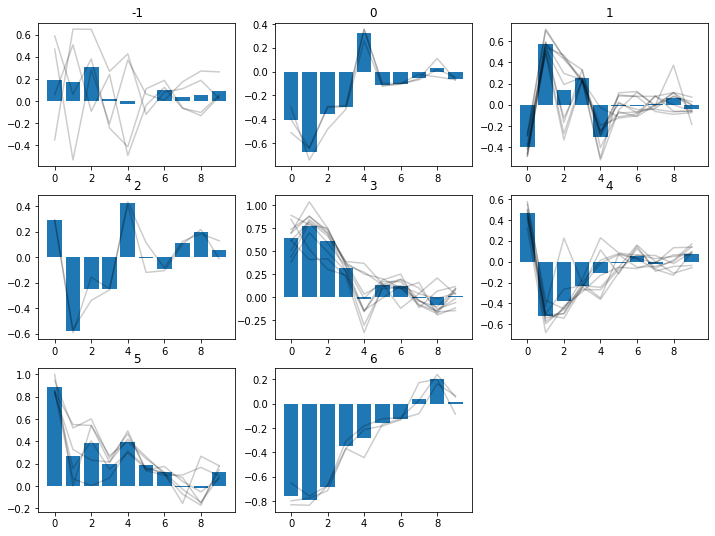

In [242]:
cols = 3
rows = int(len(np.unique(db.labels_))/cols) + 1
fig = plt.figure(figsize=(12, 3*rows))

for i, profile_mx in enumerate(profiles):
    ax = fig.add_subplot(rows, cols, i+1)
    #ax.boxplot(profile_mx, positions=np.arange(syl_count))
    for profile in profile_mx:
        ax.plot(profile, color='black', alpha=0.2)
    ax.bar(np.arange(syl_count), profile_mx.mean(axis=0))
    ax.set_title(np.unique(db.labels_)[i])
    
fig.savefig(os.path.join(report, 'MoSeq', '%s_moseq_profiles.pdf' % animal))

In [158]:
report

'/home/sobolev/nevermind/Andrey/analysis/'

In [ ]:
|